#### Humans Resources Analytics
(https://www.kaggle.com/ludobenistant/hr-analytics)

Problem: Predict if an employee is going to leave the company.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score , accuracy_score, recall_score, precision_score,confusion_matrix,precision_score,roc_curve
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
df = pd.read_csv("data/HR_comma_sep.csv")
df = df.sample(frac=1)

### Initial Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 8219 to 12763
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.3+ MB


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

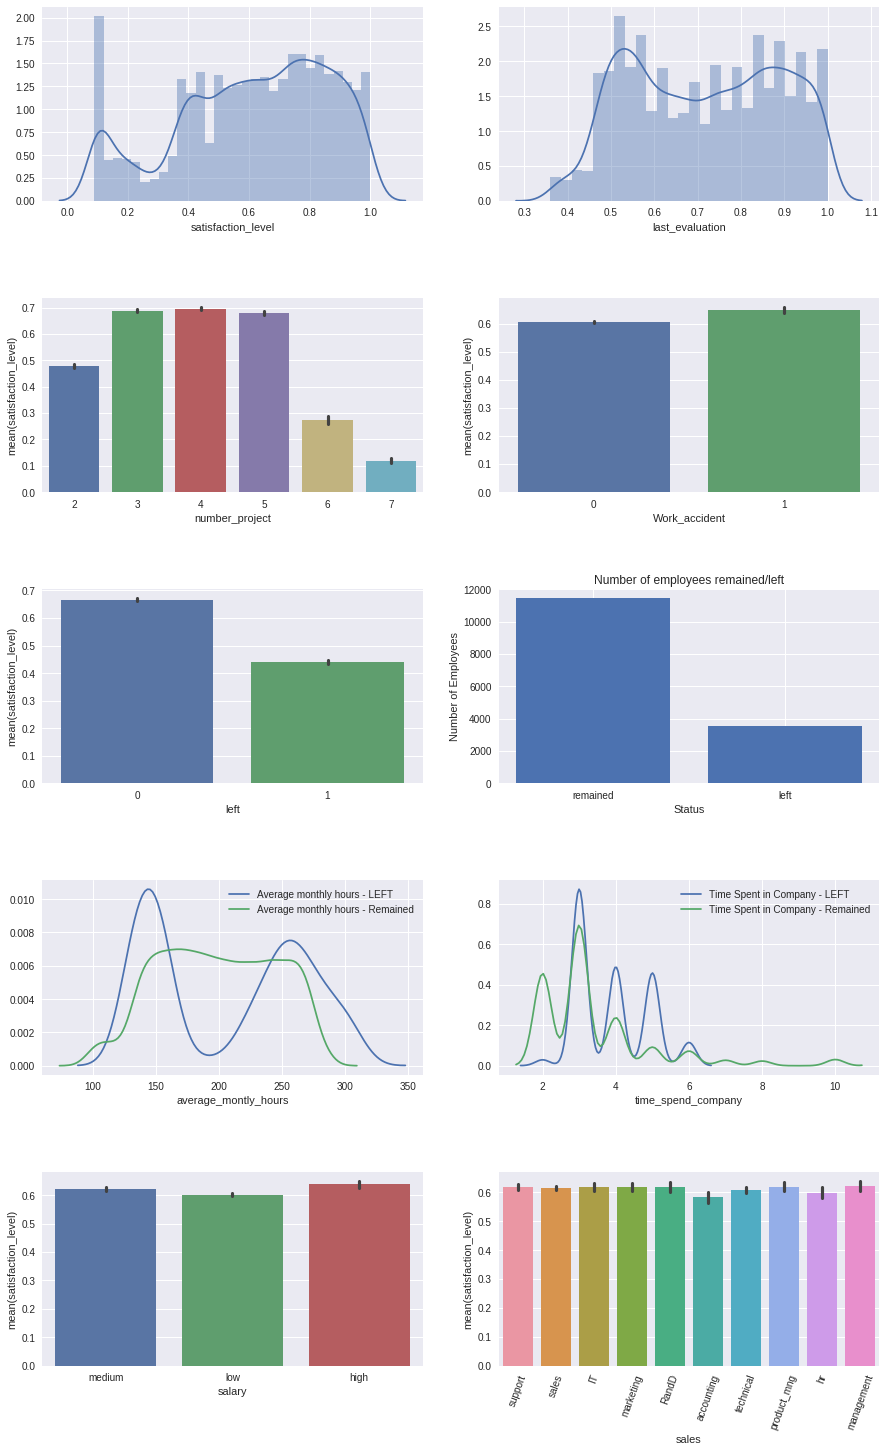

In [4]:
plt.figure(0,figsize=(15,25))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    
plt.subplot(5,2,1)
sns.distplot(df.satisfaction_level)

plt.subplot(5,2,2)
sns.distplot(df.last_evaluation)

plt.subplot(5,2,3)
sns.barplot(x="number_project", y="satisfaction_level", data=df,estimator=np.mean)

plt.subplot(5,2,4)
sns.barplot(x="Work_accident", y="satisfaction_level", data=df, estimator=np.mean)

plt.subplot(5,2,5)
sns.barplot(x="left", y="satisfaction_level", data=df, estimator=np.mean)

plt.subplot(5,2,6)
plt.bar(df.left.value_counts().index,df.left.value_counts().values,align="center",tick_label=["remained","left"])
plt.title("Number of employees remained/left")
plt.xlabel("Status")
plt.ylabel("Number of Employees")

plt.subplot(5,2,7)
sns.distplot(df[df.left == 1].average_montly_hours,hist=False,label="Average monthly hours - LEFT",norm_hist=True)
sns.distplot(df[df.left == 0].average_montly_hours,hist=False,label="Average monthly hours - Remained",norm_hist=True)

plt.subplot(5,2,8)
sns.distplot(df[df.left == 1].time_spend_company,hist=False,label="Time Spent in Company - LEFT",norm_hist=True)
sns.distplot(df[df.left == 0].time_spend_company,hist=False,label="Time Spent in Company - Remained",norm_hist=True)

plt.subplot(5,2,9)
sns.barplot(x="salary", y="satisfaction_level", data=df, estimator=np.mean)

plt.subplot(5,2,10)
sns.barplot(x="sales", y="satisfaction_level", data=df, estimator=np.mean)
plt.xticks(rotation=70)

### Feature Engineering

Here all the categorical featues are going to be one-hot-encoded. Two more features are added combining existing features in a non-linear way.

In [5]:
df["percentage_change_satisfaction_level"] = (df.satisfaction_level - df.last_evaluation)/ df.last_evaluation
df["satisfaction_times_projects"] = df.satisfaction_level * df.number_project

In [6]:
categorical_features = ["Work_accident",'promotion_last_5years','sales',"salary"]
df = pd.get_dummies(df,columns=categorical_features)

In [7]:
train_df, test_df = train_test_split(df,\
                                     test_size = 0.2,\
                                     random_state = 25)
train_df = train_df.copy()
test_df = test_df.copy()

features = [x for x in df.columns if x not in ["left"]]

#### Define Pipeline, grid_search_domain and cv scheme

The MinMaxScaler is used to keep the sparcity at the zero entries of the one-hot encoded features. Scaling is performed, especially when regularisation is used, in order to bring all the features at comparable magnitudes so that real differences between features importances can be exploited. L1 regularisation was used as a feature selection process. That way more interpretable results can be obtained as sparser solutions are obtained. The scoring function used was selected to be the roc_auc as the data set is imbalanced (the F-score could also be used). Since the classes are imbalanced (80-20) the class_weight attribute was used. Further combinations of class weights could also be tested. Finally, a stratified 5 fold scheme of cross-validation was used to generalise. Stratification was performed to preserve class distribution between the training and validation folds. 

In [8]:
#Define Pipeline
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('clf', LogisticRegression(n_jobs=-1))
    ])

#Define search area for grid_search
scale_range = [MinMaxScaler()]
clf__C_range = np.logspace(-3,2,num=50)
clf__class_weight_range = ["balanced",None]
clf__penalty_range = ["l1"]

param_grid = [{"scale":scale_range,\
               "clf__C":clf__C_range,\
               "clf__class_weight":clf__class_weight_range,\
               "clf__penalty":clf__penalty_range}]

#Define Cross validation scheme
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=25)

#### Perform Grid_seach

In [9]:
lr_model = GridSearchCV(pipe,\
                        param_grid=param_grid,\
                        scoring="roc_auc",\
                        cv=cv,\
                        n_jobs=-1,\
                        verbose=False)

lr_model.fit(train_df[features], train_df["left"])

print("parameters selected: ",lr_model.best_params_)
print(" ")
print("Cross validation score:")
print("roc_auc:",np.mean(lr_model.cv_results_['mean_test_score']))

parameters selected:  {'scale': MinMaxScaler(copy=True, feature_range=(0, 1)), 'clf__penalty': 'l1', 'clf__C': 19.306977288832496, 'clf__class_weight': 'balanced'}
 
Cross validation score:
roc_auc: 0.812023120428


#### Train again with the optimum parameters on the whole training set to get feature importances (not available through the gridsearch class)

In [16]:
#Plot importances
train_df[features] = MinMaxScaler().fit_transform(train_df[features])
lr = LogisticRegression(C=lr_model.best_params_["clf__C"],\
                        class_weight=lr_model.best_params_["clf__class_weight"],\
                        penalty=lr_model.best_params_["clf__penalty"])

lr.fit(train_df[features],train_df["left"])

LogisticRegression(C=19.306977288832496, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

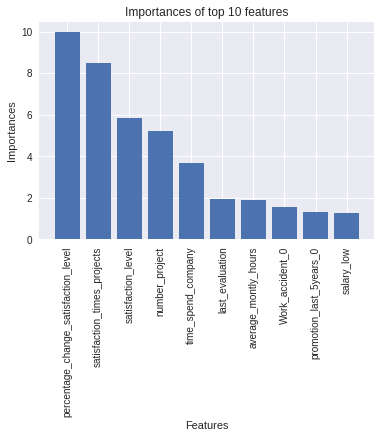

Number of features used for prediction: 22 out of 24


In [11]:
importances=pd.Series(abs(lr.coef_[0]),index=train_df[features].columns)
importances.sort_values(inplace=True,ascending=False)


plt.bar(range(0,len(importances[0:10])),importances[0:10],\
        tick_label=importances.index[0:10])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Importances of top 10 features")

plt.show()
print("Number of features used for prediction: {} out of {}".format(len(lr.coef_.nonzero()[1]),len(features)))

### Test set Evaluation

In [12]:
X_test = test_df[features]
y_test_pred = lr_model.predict(X_test)
y_test_true = test_df["left"]
y_test_pred_proba = lr_model.predict_proba(X_test)[:,1]

In [13]:
print("recall_on_test: {0:.3f}".format(recall_score(y_test_true,y_test_pred)))
print("accuracy_on_test: {0:.3f}".format(accuracy_score(y_test_true,y_test_pred)))
print("precision_on_test: {0:.3f}".format(precision_score(y_test_true,y_test_pred)))
print("roc_auc_on_test: {0:.3f}".format(roc_auc_score(y_test_true,y_test_pred_proba)))

recall_on_test: 0.842
accuracy_on_test: 0.776
precision_on_test: 0.519
roc_auc_on_test: 0.835


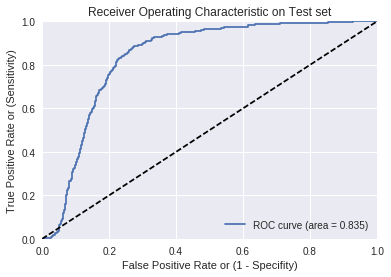

In [14]:
fpr, tpr, thresholds = roc_curve(y_true=y_test_true, y_score=y_test_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test_true,y_test_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic on Test set')
plt.legend(loc="lower right")

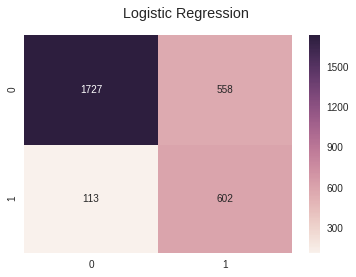

In [15]:
sns.heatmap(confusion_matrix(y_test_true, y_test_pred, labels=[0,1]),annot=True,fmt="d")
sns.set(font_scale=1)
sns.plt.suptitle('Logistic Regression')